In [73]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sails.wavelet
from neurodsp.filt import filter_signal
from sails import wavelet
import scipy.stats as stats
import emd
import tarfile
import io
from scipy import signal
from scipy import stats
from scipy import fftpack
from sympy.stats.sampling.sample_scipy import scipy
from tqdm import tqdm
from icecream import ic
import neurodsp.filt as dsp
import seaborn as sns
from skimage.feature import peak_local_max
from src.functions import tg_split
from src.functions import fpp_peaks

# Directories
Set the working directory as well as access to the main LFP dataset and supplementary dataset

In [74]:
# Set the current working directory
cwd = os.chdir(r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz")

# Access to the Steinmetz LFP dataset
lfp_dat = r"E:\Steinmetz_Dataset"

# @title Data retrieval
data_directory = r'data\spikeAndBehavioralData'

# test_dataset
test_LFP = r"Cori_2016-12-17"

In [75]:
print(os.path.join(os.getcwd(),data_directory))

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData


## Brain Regions of Interest

In [76]:
hpc = ["CA1", "CA3", "DG", "SUB"]
pfc = ["ACA", "ILA", "PL","RSP"]
region_loop = hpc + pfc
region_select = 'CA1'

## Power spectrum functions

In [77]:
def plot_power_spectrum(data, fs, nperseg=1024, noverlap=None, scaling='density', ax=None):
    """
    Plot the power spectrum of a given signal.

    Parameters:
    - data: array-like, the time series data
    - fs: float, the sampling frequency (in Hz)
    - nperseg: int, length of each segment for Welch's method (default 1024)
    - noverlap: int, number of points to overlap between segments (default None)
    - scaling: str, 'density' for PSD, 'spectrum' for power spectrum (default 'density')
    - ax: matplotlib axis object, if None a new figure is created

    Returns:
    - fig: matplotlib figure object
    - ax: matplotlib axis object
    """
    
    # Compute the power spectrum
    frequencies, psd = signal.welch(data, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling=scaling)
    
    # Create a new figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.figure
    
    # Plot the power spectrum
    ax.semilogy(frequencies, psd)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency' if scaling == 'density' else 'Power')
    ax.set_title('Power Spectrum' if scaling == 'spectrum' else 'Power Spectral Density')
    ax.grid(True)
    
    return fig, ax

In [78]:
   def analyze_channel_spectrum(signal_data, sampling_rate):
       N = len(signal_data)
       
       # Compute the FFT
       yf = signal.fft(signal_data)
       xf = signal.fftfreq(N, 1 / sampling_rate)
       
       # Compute the power spectrum
       power_spectrum = np.abs(yf)**2
       
       # Plot the power spectrum
       plt.figure(figsize=(10, 6))
       plt.plot(xf[:N//2], power_spectrum[:N//2])
       plt.xlabel('Frequency (Hz)')
       plt.ylabel('Power')
       plt.title('Power Spectrum')
       plt.grid(True)
       plt.show()

### Defining file iterator (for later use)

In [79]:
walker = os.walk(os.path.join(os.getcwd(),data_directory))
for root, dirs, files in walker:
    print(root)
    print(dirs)
    print(files)

C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz\data\spikeAndBehavioralData
[]
['Cori_2016-12-14.tar', 'Cori_2016-12-17.tar', 'Cori_2016-12-18.tar', 'Forssmann_2017-11-01.tar', 'Forssmann_2017-11-02.tar', 'Forssmann_2017-11-04.tar', 'Forssmann_2017-11-05.tar', 'Hench_2017-06-15.tar', 'Hench_2017-06-16.tar', 'Hench_2017-06-17.tar', 'Hench_2017-06-18.tar', 'Lederberg_2017-12-05.tar', 'Lederberg_2017-12-06.tar', 'Lederberg_2017-12-07.tar', 'Lederberg_2017-12-08.tar', 'Lederberg_2017-12-09.tar', 'Lederberg_2017-12-10.tar', 'Lederberg_2017-12-11.tar', 'Moniz_2017-05-15.tar', 'Moniz_2017-05-16.tar', 'Moniz_2017-05-18.tar', 'Muller_2017-01-07.tar', 'Muller_2017-01-08.tar', 'Muller_2017-01-09.tar', 'Radnitz_2017-01-08.tar', 'Radnitz_2017-01-09.tar', 'Radnitz_2017-01-10.tar', 'Radnitz_2017-01-11.tar', 'Radnitz_2017-01-12.tar', 'Richards_2017-10-29.tar', 'Richards_2017-10-30.tar', 'Richards_2017-10-31.tar', 'Richards_2017-11-01.tar', 'Richards_2017-11-02.tar', 'Tatum_2017-12-06.tar', 'Tat

### .npy file loader from tarball

In [80]:
def npy_loader(filename:str)-> np.ndarray:
    '''
    Numpy loader function for .npy in tarball (.tar) packages.
    
    :param filename: str
    :return: np.ndarray 
    '''
    try:
        npy_file = tar.extractfile(filename)
        if npy_file is not None:
            npy_file_content = npy_file.read()
            
            # Check file size to confirm it's not empty or corrupted
            if len(npy_file_content) == 0:
                raise ValueError(f"The .npy file '{filename}' is empty or corrupted.")
            
            # Load .npy file from memory using BytesIO
            np_data = np.load(io.BytesIO(npy_file_content))
            return np_data
        else:
            raise FileNotFoundError(f"Could not find or extract the file: {probe_filename}")
    except Exception as e:
        print(f"Error reading .npy file: {e}")
    

In [81]:
alldata_tar_path = os.path.join(os.getcwd(),data_directory,test_LFP + r".tar")
with tarfile.open(alldata_tar_path, 'r') as tar:
    print(tar.getnames())
    
    brain_loc_filename = [name for name in tar.getnames()[:5] if name.endswith('.tsv')][0]
    probe_desc_filename = [name for name in tar.getnames() if name.endswith('rawFilename.tsv')][0]
    probe_filename = [name for name in tar.getnames() if name.endswith('channels.probe.npy')][0]
    raw_Row_filename = [name for name in tar.getnames() if name.endswith('channels.rawRow.npy')][0]
    site_filename = [name for name in tar.getnames() if name.endswith('channels.site.npy')][0]
    site_pos_filename = [name for name in tar.getnames() if name.endswith('channels.sitePositions.npy')][0]
    
    
    brain_loc = pd.read_csv(tar.extractfile(brain_loc_filename), sep='\t')
    probe_desc = pd.read_csv(tar.extractfile(probe_desc_filename), sep='\t')
    probe = npy_loader(probe_filename)
    raw_Row = npy_loader(raw_Row_filename)
    site = npy_loader(site_filename)
    site_pos = npy_loader(site_pos_filename)
    
    

['channels.brainLocation.tsv', 'channels.probe.npy', 'channels.rawRow.npy', 'channels.site.npy', 'channels.sitePositions.npy', 'clusters.depths.npy', 'clusters.originalIDs.npy', 'clusters.peakChannel.npy', 'clusters.probes.npy', 'clusters.templateWaveformChans.npy', 'clusters.templateWaveforms.npy', 'clusters.waveformDuration.npy', 'clusters._phy_annotation.npy', 'Cori_2016-12-17_LM_g0_t0.imec.lf.timestamps.npy', 'Cori_2016-12-17_PM_g0_t0.imec.lf.timestamps.npy', 'eye.area.npy', 'eye.timestamps.npy', 'eye.xyPos.npy', 'face.motionEnergy.npy', 'face.timestamps.npy', 'lickPiezo.raw.npy', 'lickPiezo.timestamps.npy', 'licks.times.npy', 'passiveBeeps.times.npy', 'passiveValveClick.times.npy', 'passiveVisual.contrastLeft.npy', 'passiveVisual.contrastRight.npy', 'passiveVisual.times.npy', 'passiveWhiteNoise.times.npy', 'probes.description.tsv', 'probes.insertion.tsv', 'probes.rawFilename.tsv', 'probes.sitePositions.npy', 'sparseNoise.positions.npy', 'sparseNoise.times.npy', 'spikes.amps.npy', 

In [82]:
brain_loc.shape

(748, 4)

In [83]:
brain_loc.query(f'allen_ontology == "{region_select}"')

,ccf_ap,ccf_dv,ccf_lr,allen_ontology
150,8101.1,3187.8,2232.1,CA1
151,8119.9,3187.8,2258.0,CA1
152,8115.4,3168.7,2241.5,CA1
153,8134.2,3168.7,2267.4,CA1
154,8110.8,3149.6,2225.1,CA1
...,...,...,...,...
239,8348.5,2329.5,2112.0,CA1
240,8325.2,2310.4,2069.6,CA1
241,8344.0,2310.4,2095.5,CA1
242,8339.5,2291.3,2079.0,CA1


In [84]:
probe_desc

,rawFilename
0,Cori_2016-12-17_LM_g0_t0.imec.ap_CAR.bin
1,Cori_2016-12-17_PM_g0_t0.imec.ap_CAR.bin


In [85]:
brain_loc['probe'] = probe
brain_loc['site'] = site
brain_loc[['site_pos_x','site_pos_y']] = site_pos
brain_loc['raw_Row'] = raw_Row

In [86]:
brain_loc.query(f'allen_ontology == "{region_select}"')

,ccf_ap,ccf_dv,ccf_lr,allen_ontology,probe,site,site_pos_x,site_pos_y,raw_Row
150,8101.1,3187.8,2232.1,CA1,0.0,154,59.0,1560.0,154
151,8119.9,3187.8,2258.0,CA1,0.0,155,27.0,1560.0,155
152,8115.4,3168.7,2241.5,CA1,0.0,156,43.0,1580.0,156
153,8134.2,3168.7,2267.4,CA1,0.0,157,11.0,1580.0,157
154,8110.8,3149.6,2225.1,CA1,0.0,158,59.0,1600.0,158
...,...,...,...,...,...,...,...,...,...
239,8348.5,2329.5,2112.0,CA1,0.0,245,11.0,2460.0,245
240,8325.2,2310.4,2069.6,CA1,0.0,246,59.0,2480.0,246
241,8344.0,2310.4,2095.5,CA1,0.0,247,27.0,2480.0,247
242,8339.5,2291.3,2079.0,CA1,0.0,248,43.0,2500.0,248


## Discovering the Channel Labelling Scheme

<Axes: xlabel='site_pos_x', ylabel='site_pos_y'>

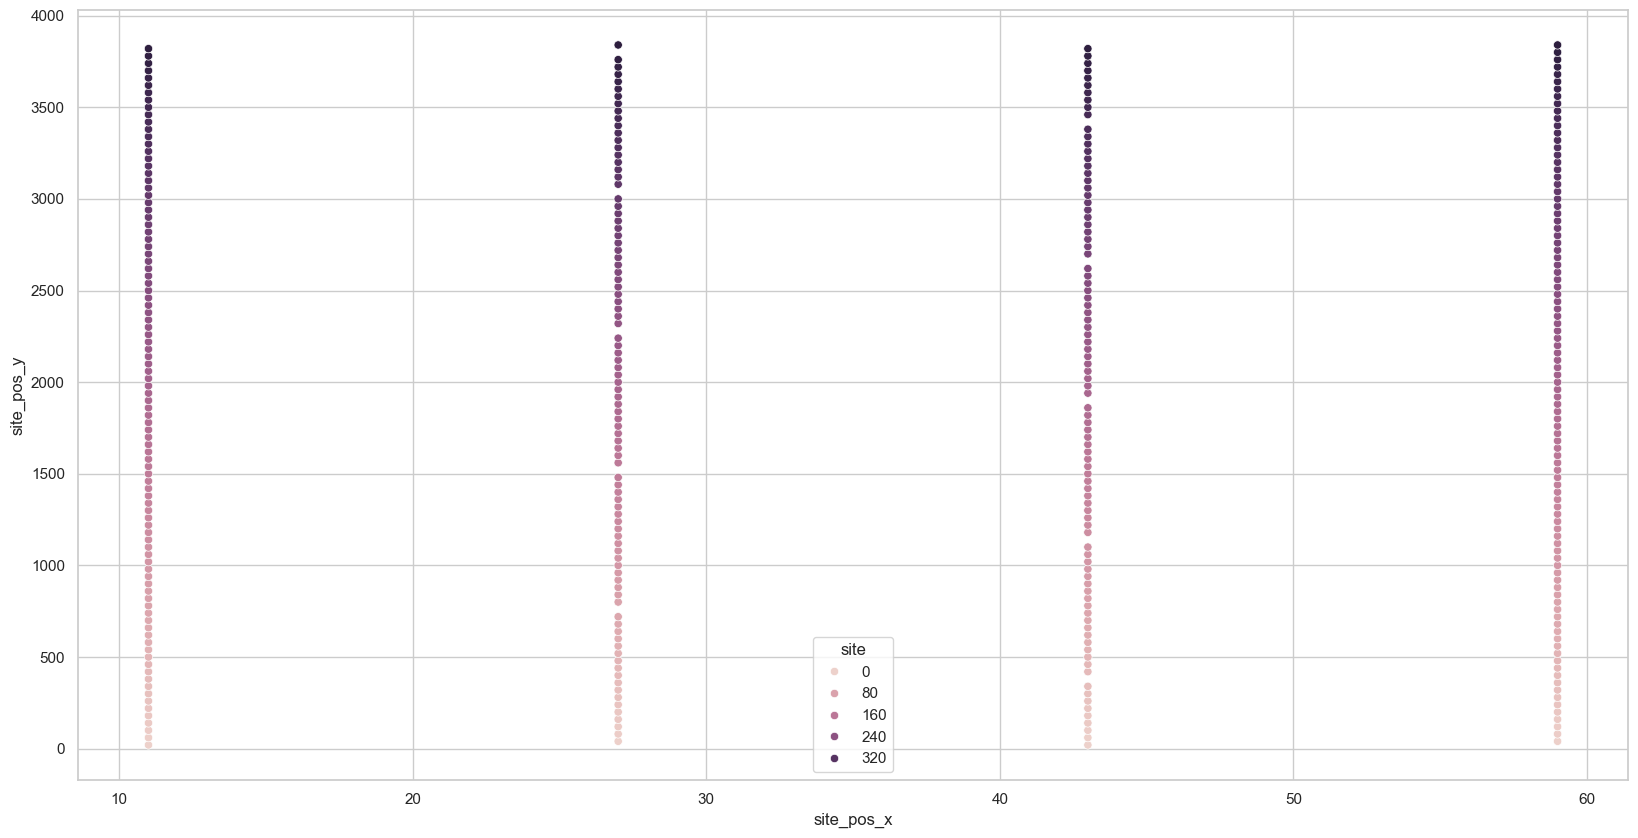

In [87]:
plt.figure(figsize=(20,10))
sns.scatterplot(brain_loc.query('probe == 0'),x='site_pos_x', y='site_pos_y', hue='site')

<Axes: xlabel='site_pos_x', ylabel='site_pos_y'>

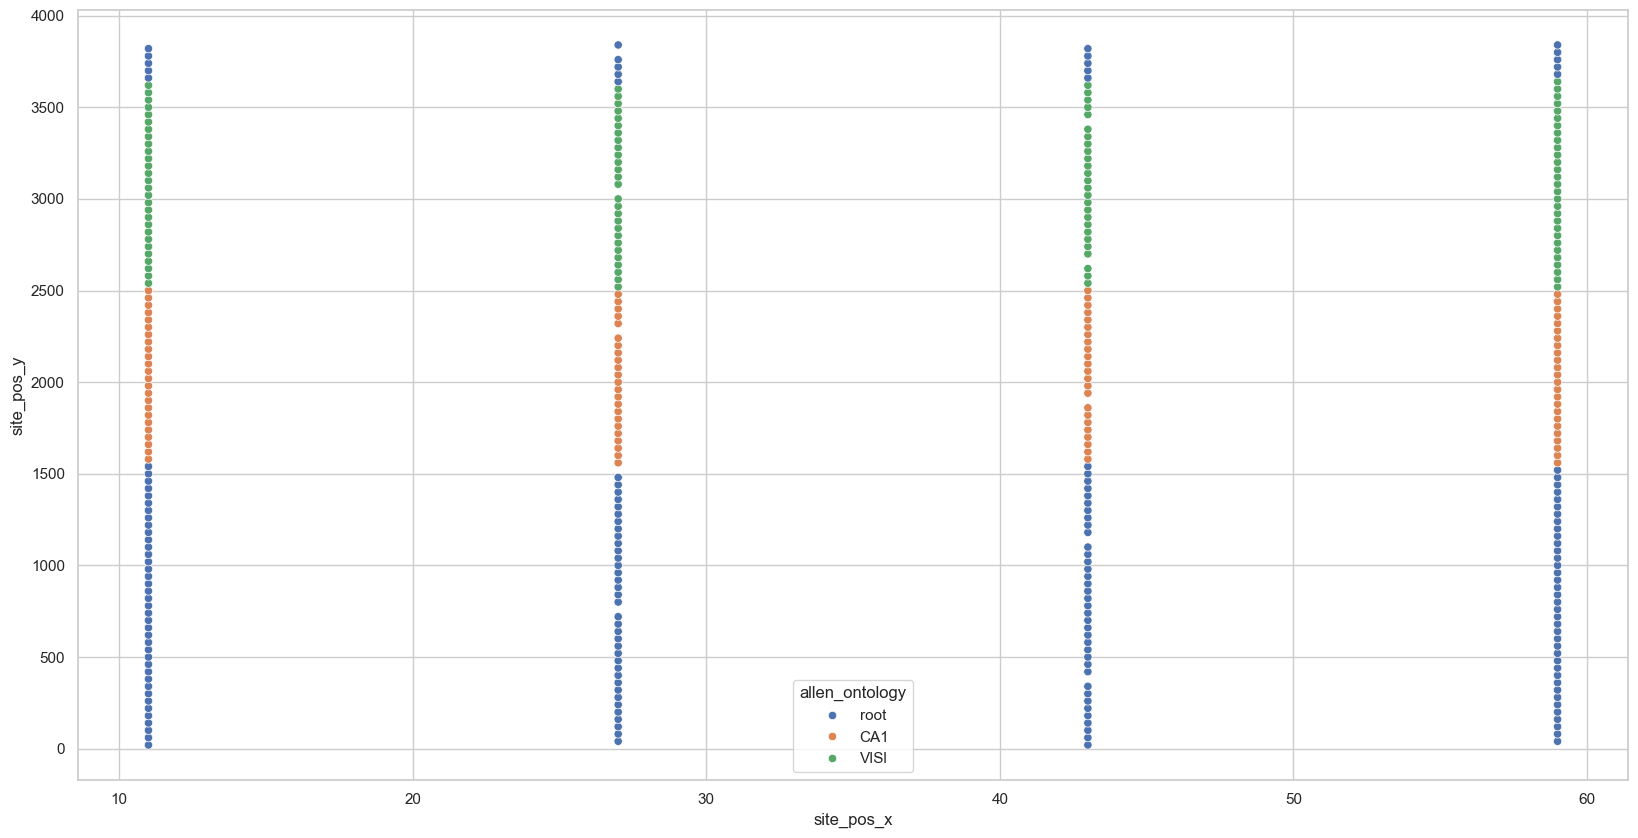

In [88]:
plt.figure(figsize=(20,10))
sns.scatterplot(brain_loc.query('probe == 0'),x='site_pos_x', y='site_pos_y', hue='allen_ontology')

### Probe Selection

Select the necessary probes that have recording sites of our brain regions of interest

In [89]:
# Identify probe for CA1
probe_select = brain_loc.query(f'allen_ontology == "{region_select}"')['probe'].unique() == np.array(probe_desc.index)

In [90]:
#TODO: Build a dataset loader that interacts with the online database

# Path to your .tar file


tar_path = os.path.join(lfp_dat,test_LFP + r"_lfp.tar")



# Define the parameters based on the documentation
num_channels = 385  # 385 channels as specified
data_type = np.int16  # int16 data type
sampling_rate = 2500  # 2500 Hz sampling rate

# Open the .tar file and load the .bin file
with tarfile.open(tar_path, 'r') as tar:
    # Identify the .bin file (assuming there's only one)
    bin_file_name = np.array(tar.getnames())[probe_select][0]
    
    
    # Extract the .bin file to memory
    bin_file = tar.extractfile(bin_file_name)
    
    # Determine the number of samples by dividing the file size by the number of channels
    # and the size of each data point (2 bytes for int16)
    file_size = tar.getmember(bin_file_name).size
    num_samples = file_size // (num_channels * np.dtype(data_type).itemsize)
    
    # Read the .bin file in chunks if it's too large for memory
    chunk_size = 1000000  # Set a reasonable chunk size
    all_data = []
    
    while True:
        # Read a chunk of data
        data_chunk = np.frombuffer(bin_file.read(chunk_size * num_channels * np.dtype(data_type).itemsize), dtype=data_type)
        if data_chunk.size == 0:
            break
        # Reshape the chunk to (num_channels, chunk_samples)
        data_chunk = data_chunk.reshape(-1, num_channels).T
        all_data.append(data_chunk)
    
    # Concatenate all chunks if the entire data needs to be loaded
    reshaped_data = np.hstack(all_data)

# At this point, reshaped_data contains the LFP data in shape (385, num_total_samples)

In [91]:
ic(reshaped_data.shape)

ic| reshaped_data.shape: (385, 7861871)


(385, 7861871)

## Synchronization Signal Channel
When plotting Channel 385, we can observe that this channel contains our time events of stimulus being presented

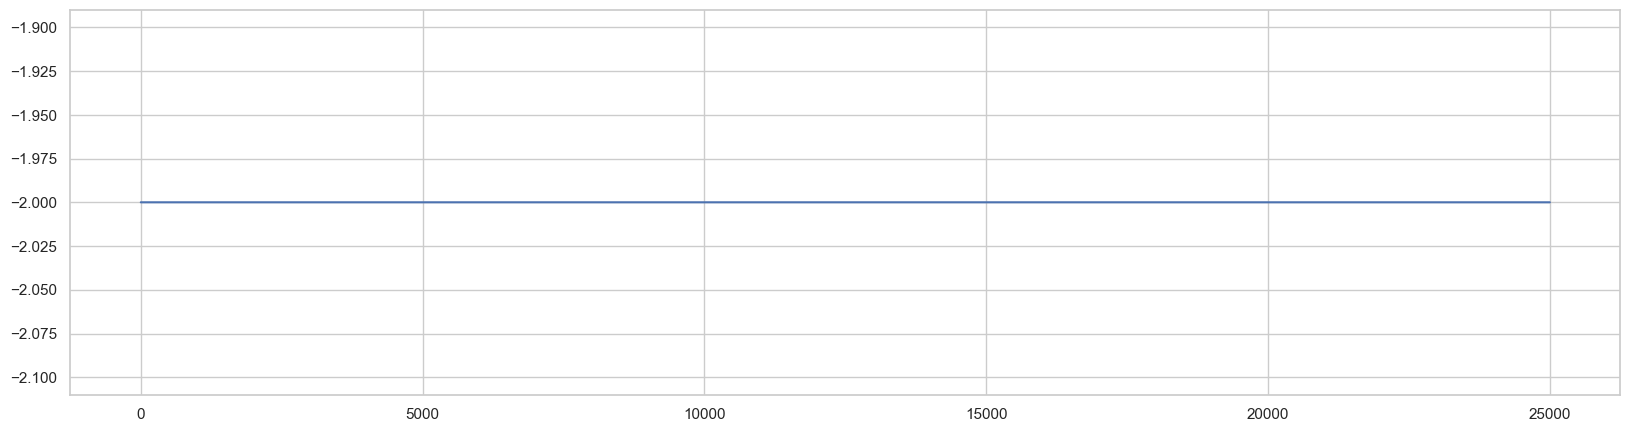

In [92]:
plt.figure(figsize=(20,5))
plt.plot(reshaped_data[-1, 180000:205000]) 

### Plot of a random CA1 channel

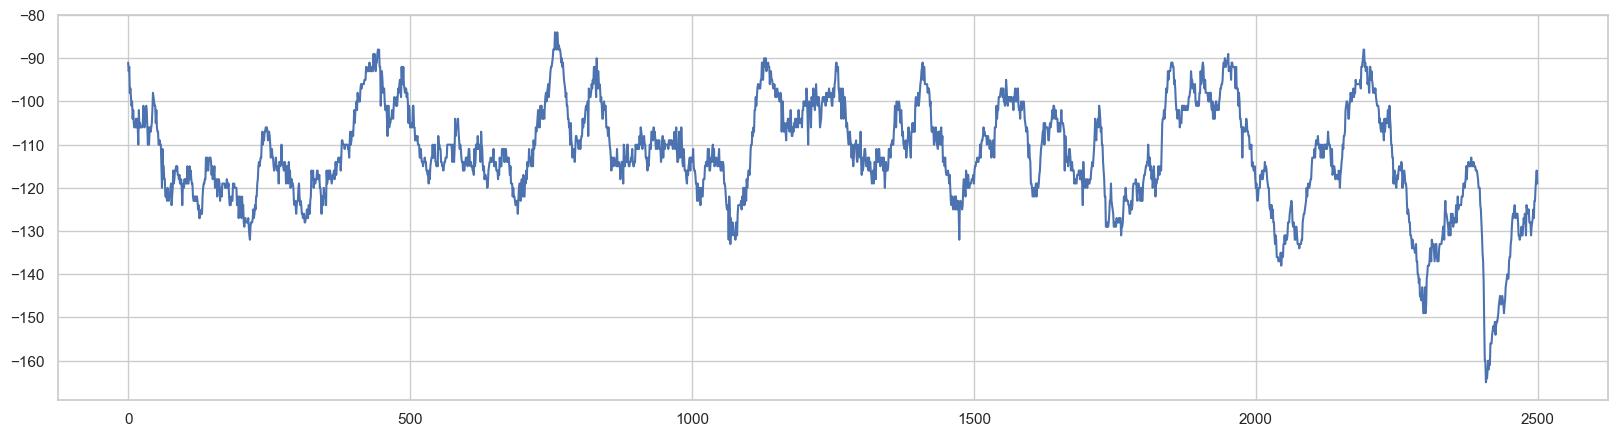

In [93]:
plt.figure(figsize=(20,5))
plt.plot(reshaped_data[233, :2500]) 

### Line Noise
Let's look for any line noise interference in our supposed region of interest

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

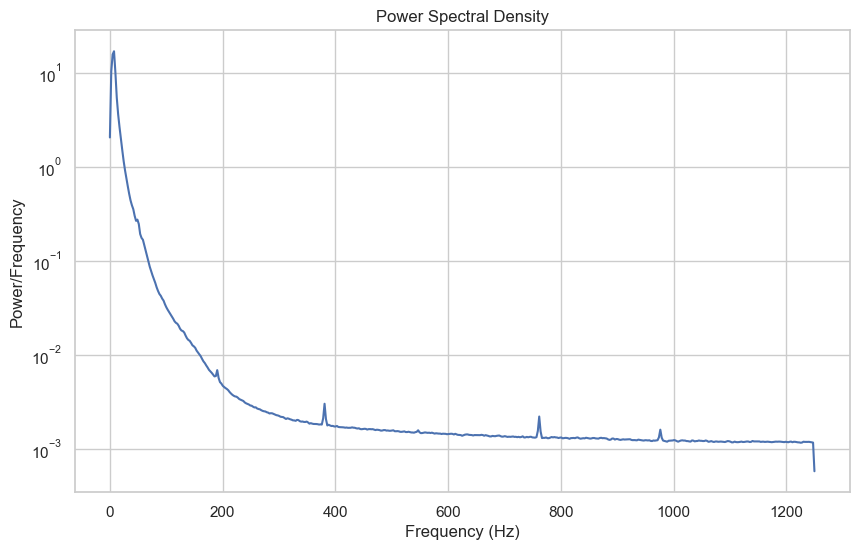

In [94]:
plot_power_spectrum(reshaped_data[233,:],2500)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

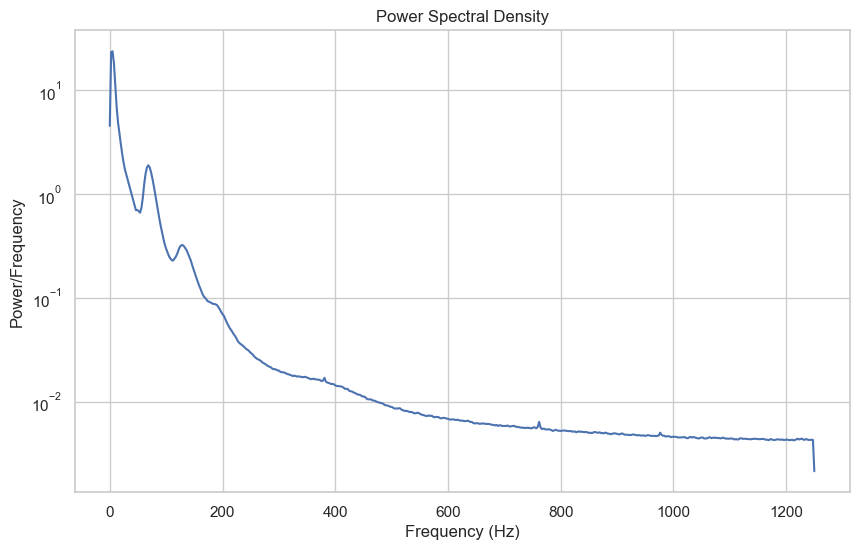

In [95]:
plot_power_spectrum(reshaped_data[0,:],2500)

In [96]:
# Retrieves the reference to subtract from the signal
def CAR_filter(signal, mode ='mean'):
    avg_ref = np.zeros((signal.shape[0],1))
    if mode == 'mean':
        avg_ref = np.mean(signal,axis=0)
    if mode == 'median':
        avg_ref = np.median(signal,axis=0)
    return avg_ref

In [97]:
avg_ref = CAR_filter(reshaped_data[:-1], mode='median')

### Selecting regions of interests
We would like to look at CA1 region in the hippocampus as an exercise first

In [98]:
select_channels = reshaped_data[brain_loc.query(f'allen_ontology == "{region_select}"')['raw_Row'].unique()] - avg_ref


In [99]:
print(select_channels.shape)

(94, 7861871)


In [100]:
print(np.mean(select_channels,axis=0).shape)

(7861871,)


### CA1 Channels Mean and Standard Deviations

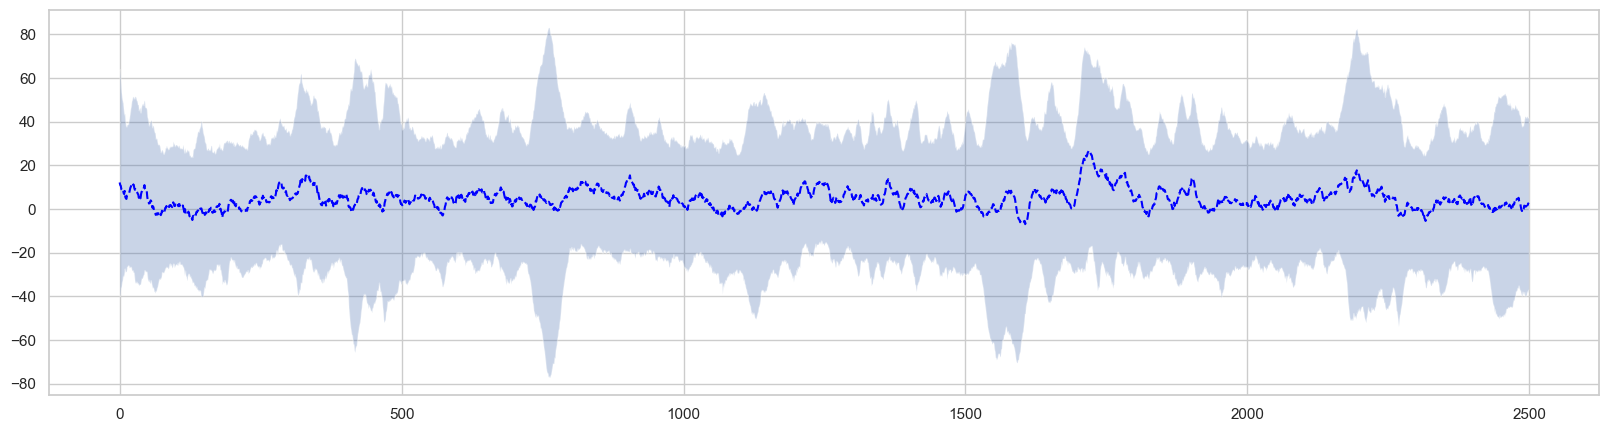

In [101]:
plt.figure(figsize=(20,5))
plt.plot(np.mean(select_channels,axis=0)[:2500], linestyle='dashed', color='blue')
plt.fill_between(range(len(np.mean(select_channels,axis=0)[:2500])), np.mean(select_channels,axis=0)[:2500]+2*np.std(select_channels,axis=0)[:2500],np.mean(select_channels,axis=0)[:2500]-2*np.std(select_channels,axis=0)[:2500],alpha=0.3)

In [102]:
# A highpass filter to isolate higher frequencies in each channel

select_filtered_channels = dsp.filter_signal(select_channels,2500,'highpass',(150,250), filter_type='iir',butterworth_order=3)


C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


In [103]:
print(select_filtered_channels.shape)

(94, 7861871)


### Comparison of a raw CA1 LFP with respect to higher frequencies

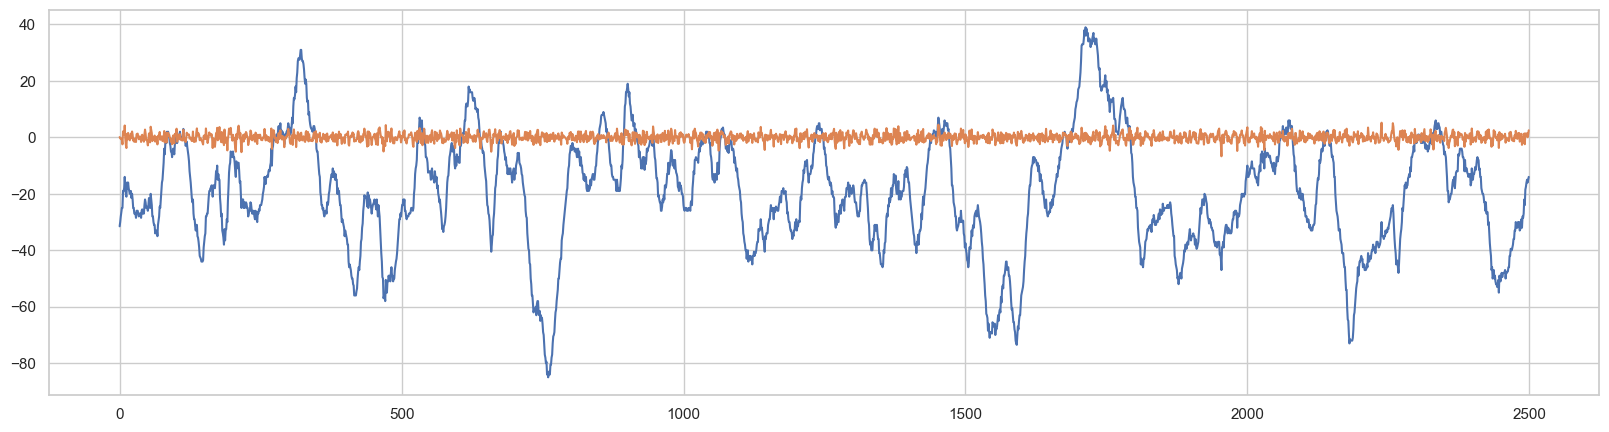

In [104]:
plt.figure(figsize=(20,5))
plt.plot(select_channels[0,:2500])
plt.plot(select_filtered_channels[0,:2500])

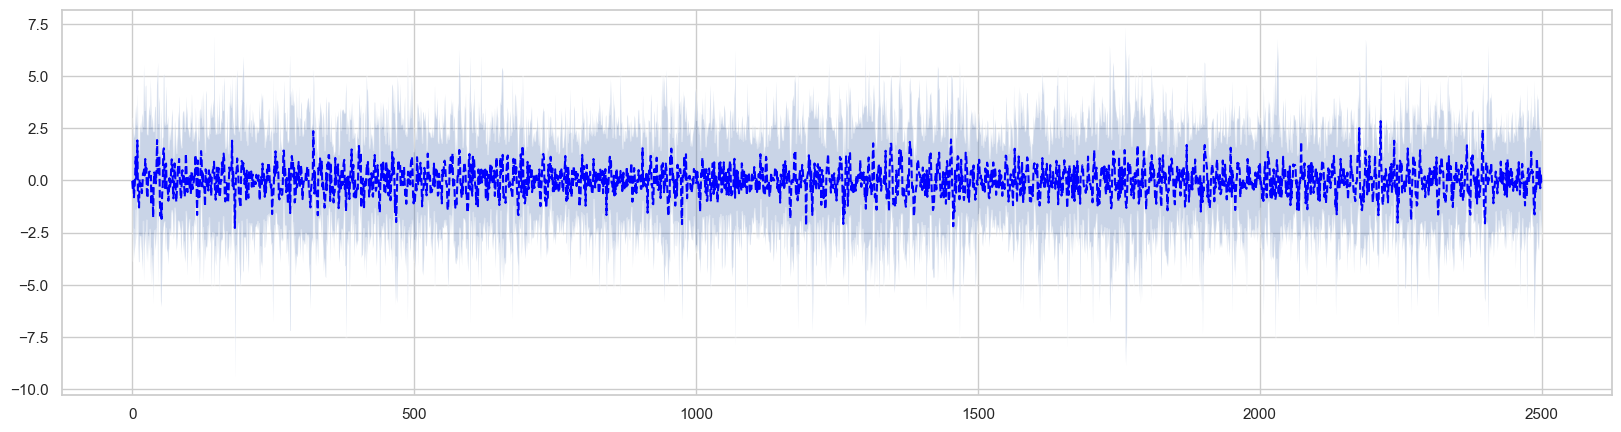

In [105]:
plt.figure(figsize=(20,5))
plt.plot(np.mean(select_filtered_channels,axis=0)[:2500],linestyle='dashed', color='blue')
plt.fill_between(range(len(np.mean(select_filtered_channels,axis=0)[:2500])), np.mean(select_filtered_channels,axis=0)[:2500]+2*np.std(select_filtered_channels,axis=0)[:2500],np.mean(select_filtered_channels,axis=0)[:2500]-2*np.std(select_filtered_channels,axis=0)[:2500],alpha=0.3)

In [106]:
# Root mean square function for calculating max ripple power
def rms (signal):
    rms = np.sqrt(np.mean(np.square(signal),axis=1))
    return rms

In [107]:
ripple_power = rms(select_filtered_channels)

In [108]:
optimum_channel = np.where(ripple_power==np.max(ripple_power))[0][0]
print(optimum_channel)

59


### Power spectrum after selecting the best HPC channel

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

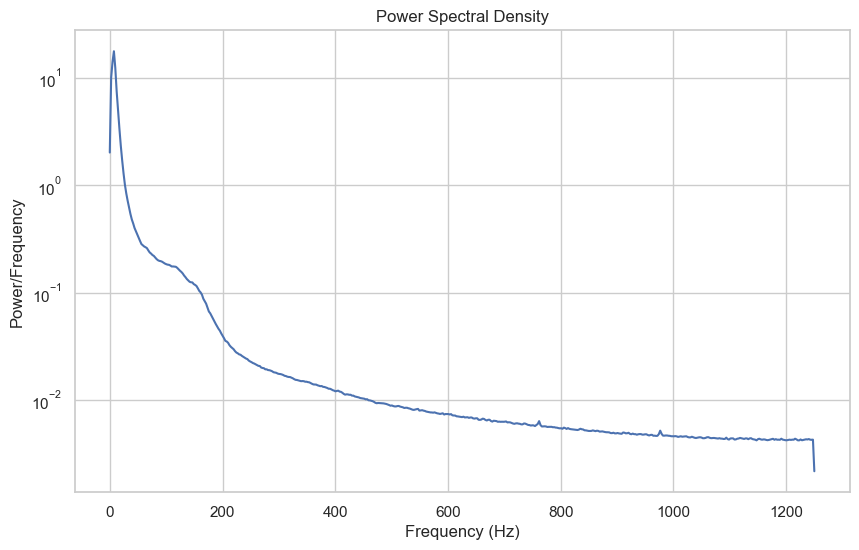

In [109]:
plot_power_spectrum(select_channels[optimum_channel,:],2500)

In [110]:
# Lowpass filter to cutoff frequencies above 200 Hz

filtered_LFP = dsp.filter_signal(select_channels[optimum_channel],2500,'lowpass',(None,200), filter_type='iir',butterworth_order=4)

C:\Python Work Directory\neuromatch\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Power Spectral Density'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency'>)

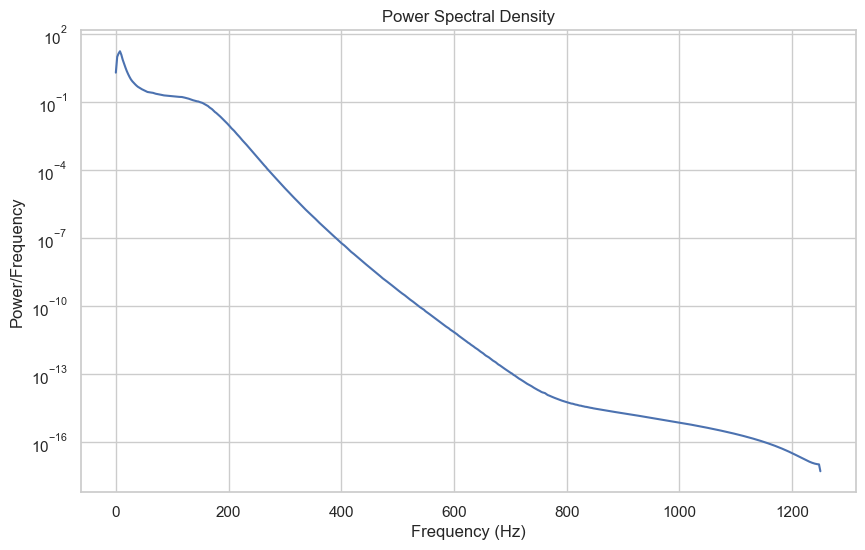

In [111]:
plot_power_spectrum(filtered_LFP,2500)

In [112]:
# Import Theta Cycle Extraction and Data Management Class Functions
from src.signal import *
from src.functions import peak_cog, fpp_peaks


In [113]:
# Intialize with selecting the optimum channel RAW LFP
wake_test_one = WakeSignal(select_channels[optimum_channel],2500,(5,12))

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [114]:
print(wake_test_one.mask_freq)

[440.02948829 125.95838628  42.14713169  12.40886468   6.23978742
   2.48420885]


<Axes: xlabel='Time (samples)'>

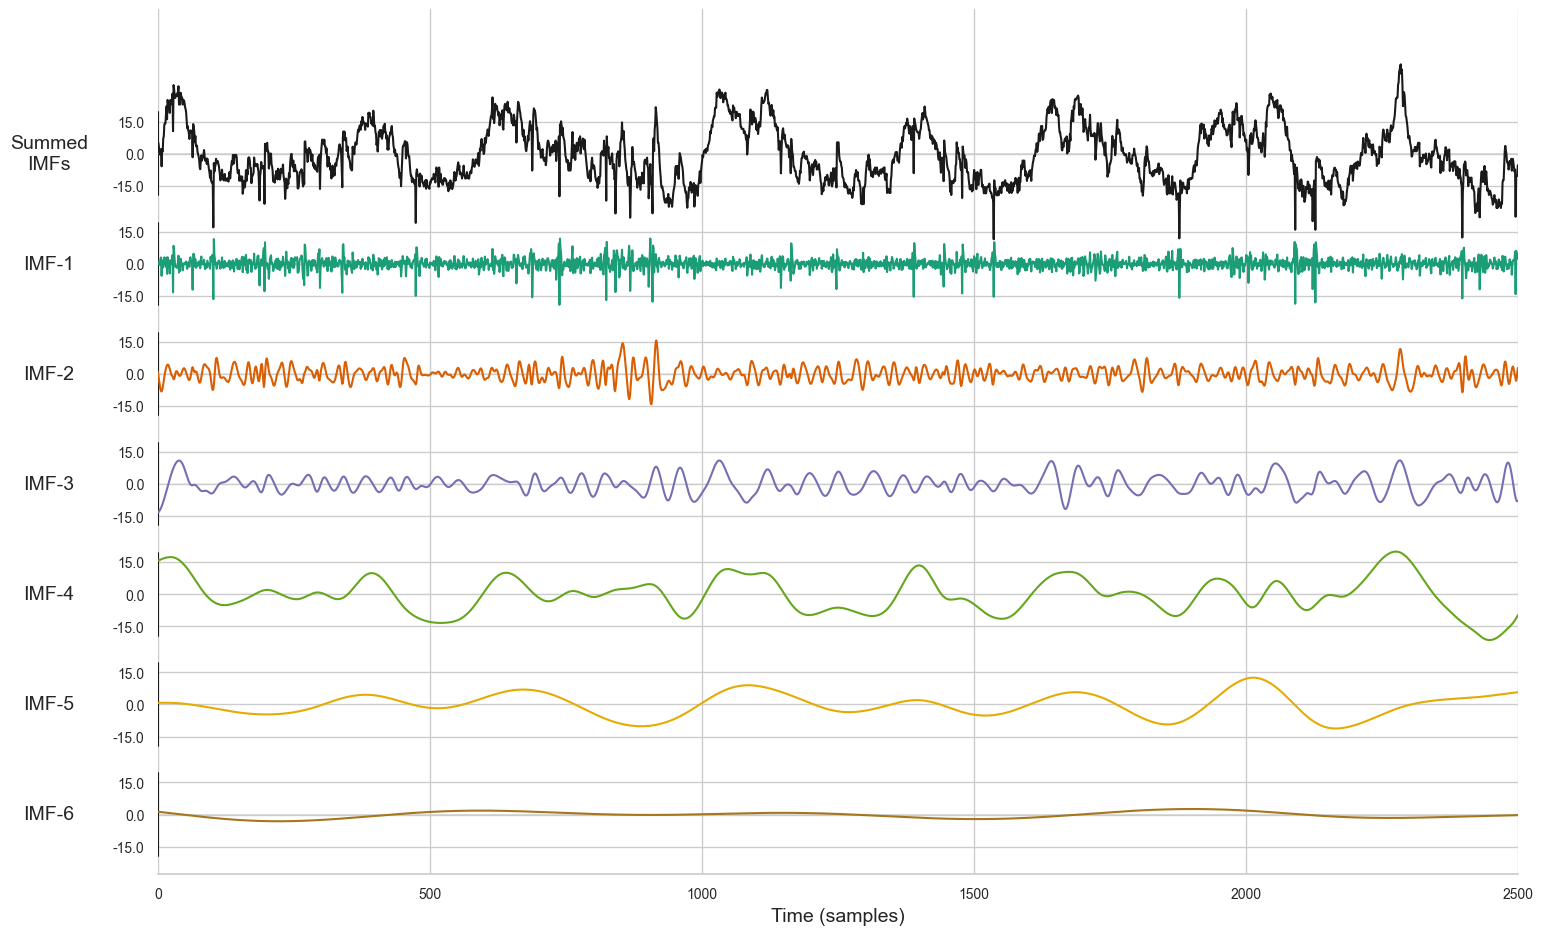

In [115]:
emd.plotting.plot_imfs(wake_test_one.imf[2500:5000])

In [116]:
sub, theta, gamma = tg_split(wake_test_one.mask_freq,wake_test_one.freq_range)
print(theta)

[False False False False  True False]


In [117]:
wake_test_one.frequency_transform('hilbert')

(array([[1.57079633, 1.18096643, 1.57079633, 1.4570579 , 1.57079633,
         0.13332723],
        [1.88999671, 1.18096643, 1.57079633, 1.41668606, 1.58342236,
         0.13332723],
        [2.87081604, 1.18096643, 1.61702413, 1.41668606, 1.59035407,
         0.13332723],
        ...,
        [5.98134799, 5.75198455, 0.38572641, 1.464224  , 1.56344068,
         6.03516803],
        [5.98134799, 5.75198455, 0.31392534, 1.464224  , 1.55570896,
         6.03516803],
        [5.98134799, 5.75198455, 0.25647297, 1.464224  , 1.24908982,
         6.03516803]]),
 array([[1.57079633, 1.18096643, 1.57079633, 1.4570579 , 1.57079633,
         0.13332723],
        [1.88999671, 1.18096643, 1.57079633, 1.41668606, 1.58342236,
         0.13332723],
        [2.87081604, 1.18096643, 1.61702413, 1.41668606, 1.59035407,
         0.13332723],
        ...,
        [5.98134799, 5.75198455, 0.38572641, 1.464224  , 1.56344068,
         6.03516803],
        [5.98134799, 5.75198455, 0.31392534, 1.464224  , 1.555

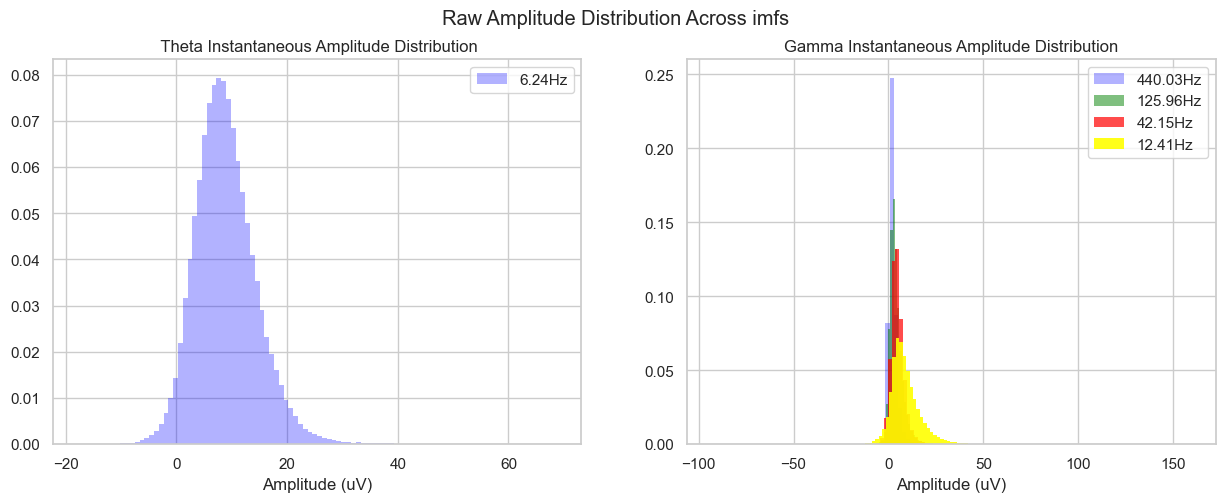

In [118]:
fig_freq,ax_freq=plt.subplots(1,2,figsize=(15,5))
colors = ['blue','green','red', 'yellow']
## Iterated Mask Sift 
for i, thet in enumerate(wake_test_one.mask_freq[theta]):
    ax_freq[0].hist(wake_test_one.IA.T[theta][i],bins=100,edgecolor='none',alpha=0.3 + (0.2*i),color= colors[i],label = str(np.round(thet,2))+ 'Hz',density=True)
ax_freq[0].legend(loc='upper right')

for j, gam in enumerate(wake_test_one.mask_freq[gamma]):
    ax_freq[1].hist(wake_test_one.IA.T[gamma][j],bins=100,edgecolor='none',alpha=0.3 + (0.2*j),color=colors[j],label = str(np.round(gam,2))+ 'Hz',density=True)
ax_freq[1].legend(loc='upper right')

ax_freq[0].set_title(' Theta Instantaneous Amplitude Distribution')
ax_freq[1].set_title('Gamma Instantaneous Amplitude Distribution')
ax_freq[0].set_xlabel(r'Amplitude (uV)')
ax_freq[1].set_xlabel(r'Amplitude (uV)')
fig_freq.suptitle('Raw Amplitude Distribution Across imfs')
fig_freq.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_RawAmplitude_Distribution.png'))

In [119]:
# Extract cycles that satisfy thresholds
fpp_cycles_one = wake_test_one.get_fpp_cycles(frequencies=(15,120), band = 'gamma', norm='zscore', mode = 'power')

In [120]:
print(fpp_cycles_one.shape)

(12921, 106, 19)


In [121]:
# Intialize with selecting the optimum channel RAW LFP minus the high frequency components using EMD
wake_test_two = WakeSignal(np.sum(wake_test_one.imf[:,1:],axis=1),2500,(5,12))

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [122]:
print(wake_test_two.mask_freq)

[117.63902751  30.94428604   9.79434452   4.72064824   2.03273069
   0.78222513]


<Axes: xlabel='Time (samples)'>

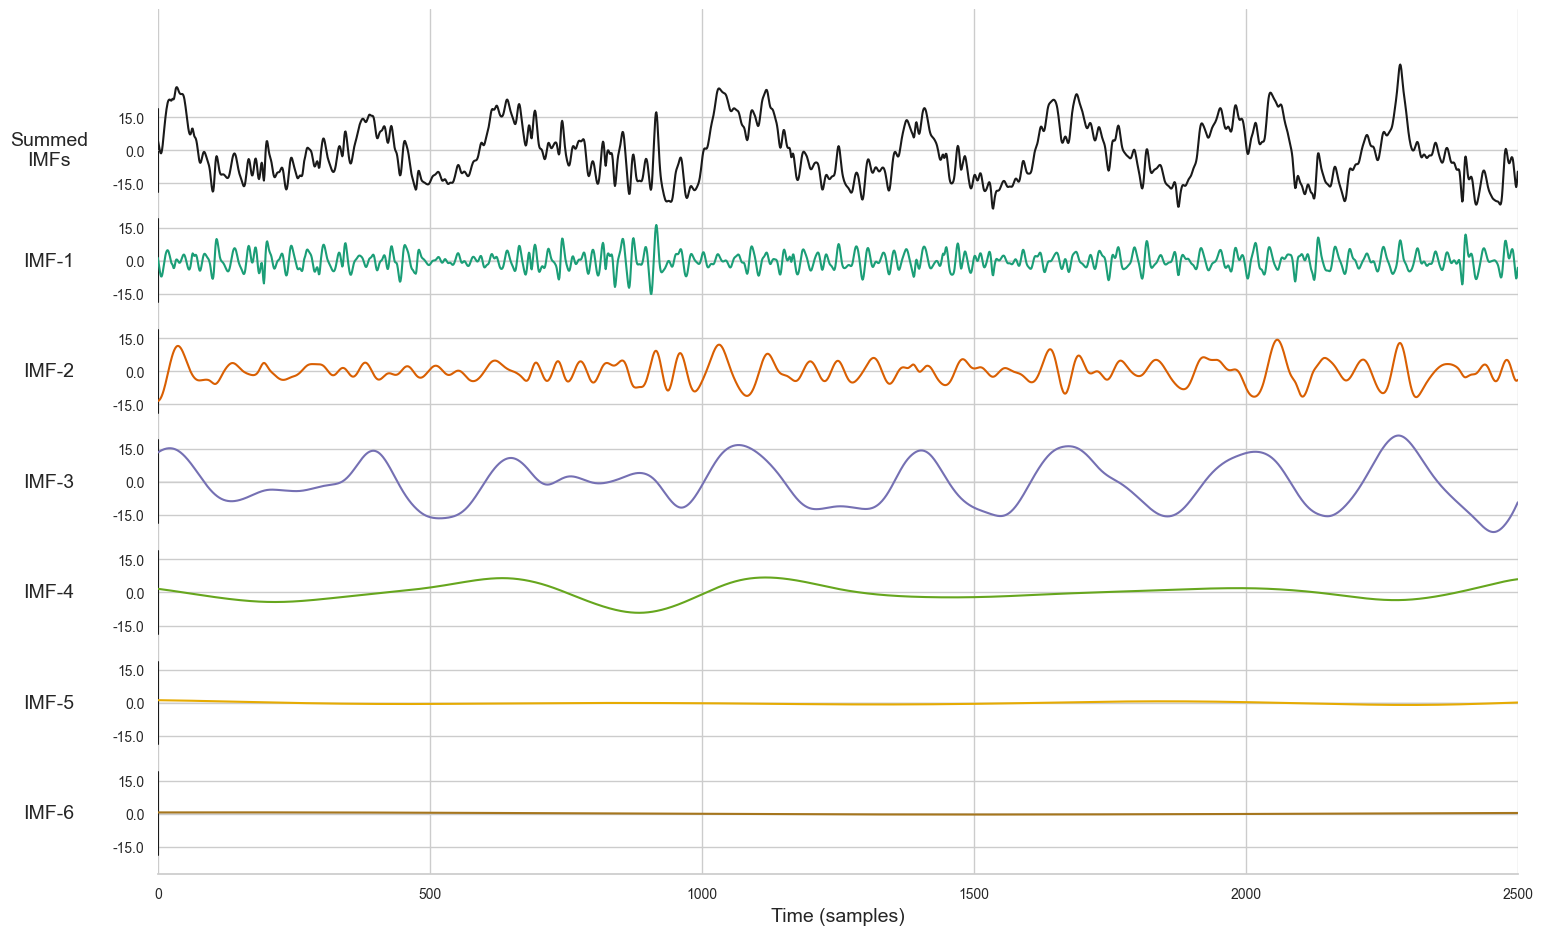

In [123]:
emd.plotting.plot_imfs(wake_test_two.imf[2500:5000])

In [124]:
wake_test_two.frequency_transform('hilbert')

(array([[1.22164983e+00, 7.78572889e-01, 1.57079633e+00, 2.54639817e+00,
         2.62425913e-03, 1.13068976e-01],
        [1.22164983e+00, 7.78572889e-01, 1.55719983e+00, 2.54639817e+00,
         2.62425913e-03, 1.13068976e-01],
        [1.22164983e+00, 7.78572889e-01, 1.55312205e+00, 2.54639817e+00,
         2.62425913e-03, 1.13068976e-01],
        ...,
        [5.56769672e+00, 1.04777158e-01, 1.58174531e+00, 2.33377430e+00,
         5.91827580e+00, 5.88005377e+00],
        [5.56769672e+00, 1.03420998e-01, 1.58174531e+00, 2.33377430e+00,
         5.91827580e+00, 5.88005377e+00],
        [5.56769672e+00, 6.81586471e-02, 1.58174531e+00, 2.33377430e+00,
         5.91827580e+00, 5.88005377e+00]]),
 array([[1.22164983e+00, 7.78572889e-01, 1.57079633e+00, 2.54639817e+00,
         2.62425913e-03, 1.13068976e-01],
        [1.22164983e+00, 7.78572889e-01, 1.55719983e+00, 2.54639817e+00,
         2.62425913e-03, 1.13068976e-01],
        [1.22164983e+00, 7.78572889e-01, 1.55312205e+00, 2.546398

In [125]:
sub, theta, gamma = tg_split(wake_test_two.mask_freq,wake_test_two.freq_range)

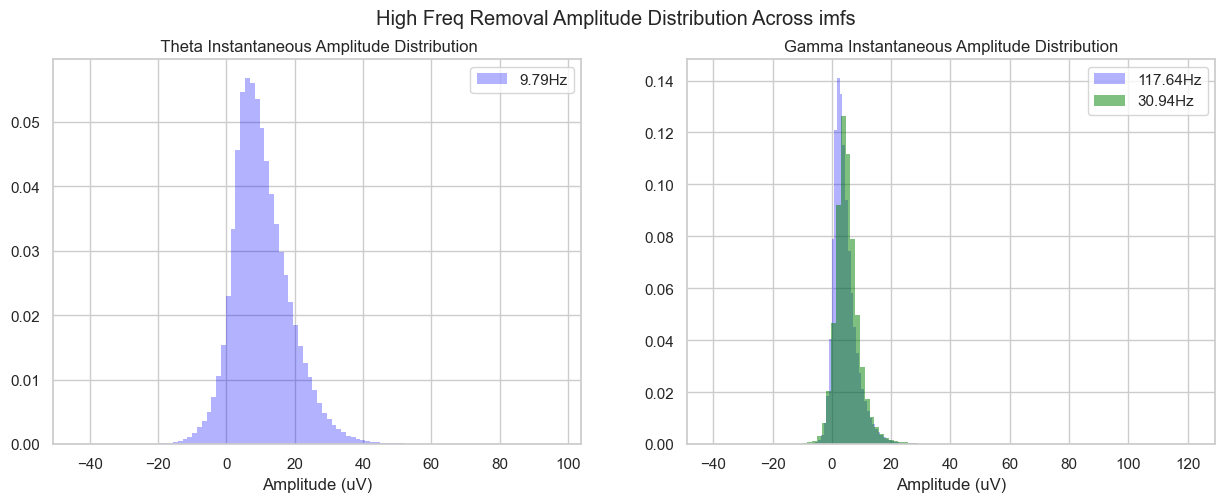

In [126]:
fig_freq2, ax_freq2 = plt.subplots(1, 2, figsize=(15, 5))
colors = ['blue', 'green', 'red']
## Iterated Mask Sift 
for i, thet in enumerate(wake_test_two.mask_freq[theta]):
    ax_freq2[0].hist(wake_test_two.IA.T[theta][i], bins=100, edgecolor='none', alpha=0.3 + (0.2 * i), color=colors[i],
                    label=str(np.round(thet, 2)) + 'Hz', density=True)
ax_freq2[0].legend(loc='upper right')

for j, gam in enumerate(wake_test_two.mask_freq[gamma]):
    ax_freq2[1].hist(wake_test_two.IA.T[gamma][j], bins=100, edgecolor='none', alpha=0.3 + (0.2 * j), color=colors[j],
                    label=str(np.round(gam, 2)) + 'Hz', density=True)
ax_freq2[1].legend(loc='upper right')

ax_freq2[0].set_title(' Theta Instantaneous Amplitude Distribution')
ax_freq2[1].set_title('Gamma Instantaneous Amplitude Distribution')
ax_freq2[0].set_xlabel(r'Amplitude (uV)')
ax_freq2[1].set_xlabel(r'Amplitude (uV)')
fig_freq2.suptitle('High Freq Removal Amplitude Distribution Across imfs')
fig_freq2.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_HighFreqRemovalAmplitude_Distribution.png'))

In [127]:
fpp_cycles_two = wake_test_two.get_fpp_cycles(frequencies=(15,120), band = 'gamma',norm='zscore', mode = 'power')

In [128]:
# Intialize with selecting the using low pass filtered LFP
wake_test_three = WakeSignal(filtered_LFP,2500,(5,12))
fpp_cycles_three = wake_test_three.get_fpp_cycles(frequencies=(15,120), band = 'gamma', norm='zscore', mode = 'power')

ic| 'No imf data, generating imfs....'
ic| 'No cycle data, extracting cycles....'


In [129]:
print(wake_test_three.mask_freq)

[106.53858718  25.99925896   8.99570005   4.1375094    1.65141233
   0.71924383]


In [130]:
wake_test_three.frequency_transform('hilbert')

(array([[1.57079633, 3.45546421, 1.40510825, 1.57079633, 4.61797661,
         6.25241392],
        [1.57079633, 3.942245  , 1.40510825, 1.57891005, 5.15181803,
         6.24139801],
        [1.62521752, 3.95651906, 1.40510825, 1.58301777, 5.15356113,
         6.24120126],
        ...,
        [5.66612375, 2.06653583, 1.40993587, 1.57288865, 6.06393714,
         5.72312745],
        [5.66612375, 2.06653583, 1.40993587, 1.57097701, 6.06356072,
         5.72312745],
        [5.66612375, 2.06653583, 1.40993587, 1.06476542, 4.00158571,
         5.72312745]]),
 array([[1.57079633, 3.45546421, 1.40510825, 1.57079633, 4.61797661,
         6.25241392],
        [1.57079633, 3.942245  , 1.40510825, 1.57891005, 5.15181803,
         6.24139801],
        [1.62521752, 3.95651906, 1.40510825, 1.58301777, 5.15356113,
         6.24120126],
        ...,
        [5.66612375, 2.06653583, 1.40993587, 1.57288865, 6.06393714,
         5.72312745],
        [5.66612375, 2.06653583, 1.40993587, 1.57097701, 6.063

In [131]:
sub, theta, gamma = tg_split(wake_test_three.mask_freq,wake_test_three.freq_range)

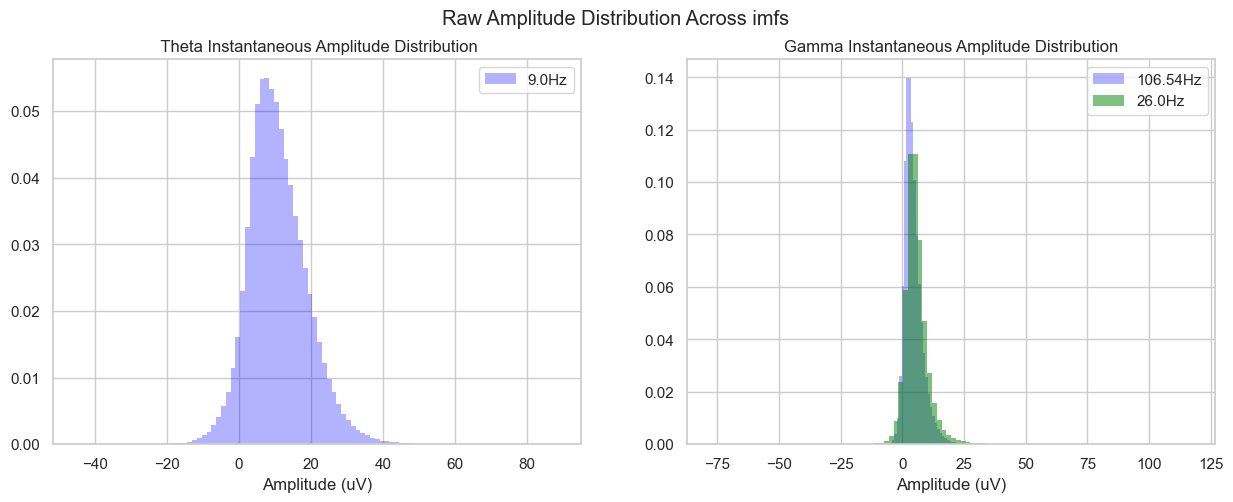

In [132]:
fig_freq3, ax_freq3 = plt.subplots(1, 2, figsize=(15, 5))
colors = ['blue', 'green', 'red']
## Iterated Mask Sift 
for i, thet in enumerate(wake_test_three.mask_freq[theta]):
    ax_freq3[0].hist(wake_test_three.IA.T[theta][i], bins=100, edgecolor='none', alpha=0.3 + (0.2 * i), color=colors[i],
                    label=str(np.round(thet, 2)) + 'Hz', density=True)
ax_freq3[0].legend(loc='upper right')

for j, gam in enumerate(wake_test_three.mask_freq[gamma]):
    ax_freq3[1].hist(wake_test_three.IA.T[gamma][j], bins=100, edgecolor='none', alpha=0.3 + (0.2 * j), color=colors[j],
                    label=str(np.round(gam, 2)) + 'Hz', density=True)
ax_freq3[1].legend(loc='upper right')

ax_freq3[0].set_title(' Theta Instantaneous Amplitude Distribution')
ax_freq3[1].set_title('Gamma Instantaneous Amplitude Distribution')
ax_freq3[0].set_xlabel(r'Amplitude (uV)')
ax_freq3[1].set_xlabel(r'Amplitude (uV)')
fig_freq3.suptitle('Raw Amplitude Distribution Across imfs')
fig_freq3.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_LowPassFiltAmplitude_Distribution.png'))

In [133]:
# Generate center of gravity peaks for each cycle
peaks_one = wake_test_one.peak_center_of_gravity(frequencies=(15,120), band = 'gamma', norm='zscore', mode = 'power')
peaks_two = wake_test_two.peak_center_of_gravity(frequencies=(15,120), band = 'gamma', norm='zscore', mode = 'power')
peaks_three = wake_test_three.peak_center_of_gravity(frequencies=(15,120), band = 'gamma', norm='zscore', mode = 'power')

In [134]:
# Generate all peaks from FPP topology
fpp_peaks_one = wake_test_one.get_fpp_peaks(frequencies=(15,120))
fpp_peaks_two = wake_test_two.get_fpp_peaks(frequencies=(15,120))
fpp_peaks_three = wake_test_three.get_fpp_peaks(frequencies=(15,120))

In [135]:
print(fpp_cycles_two.shape)
print(fpp_cycles_three.shape)

(14565, 106, 19)
(16310, 106, 19)


In [136]:
frequencies = np.arange(15,121,1)
angles = np.linspace(-180,180,19)
print(angles)

[-180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.   40.
   60.   80.  100.  120.  140.  160.  180.]


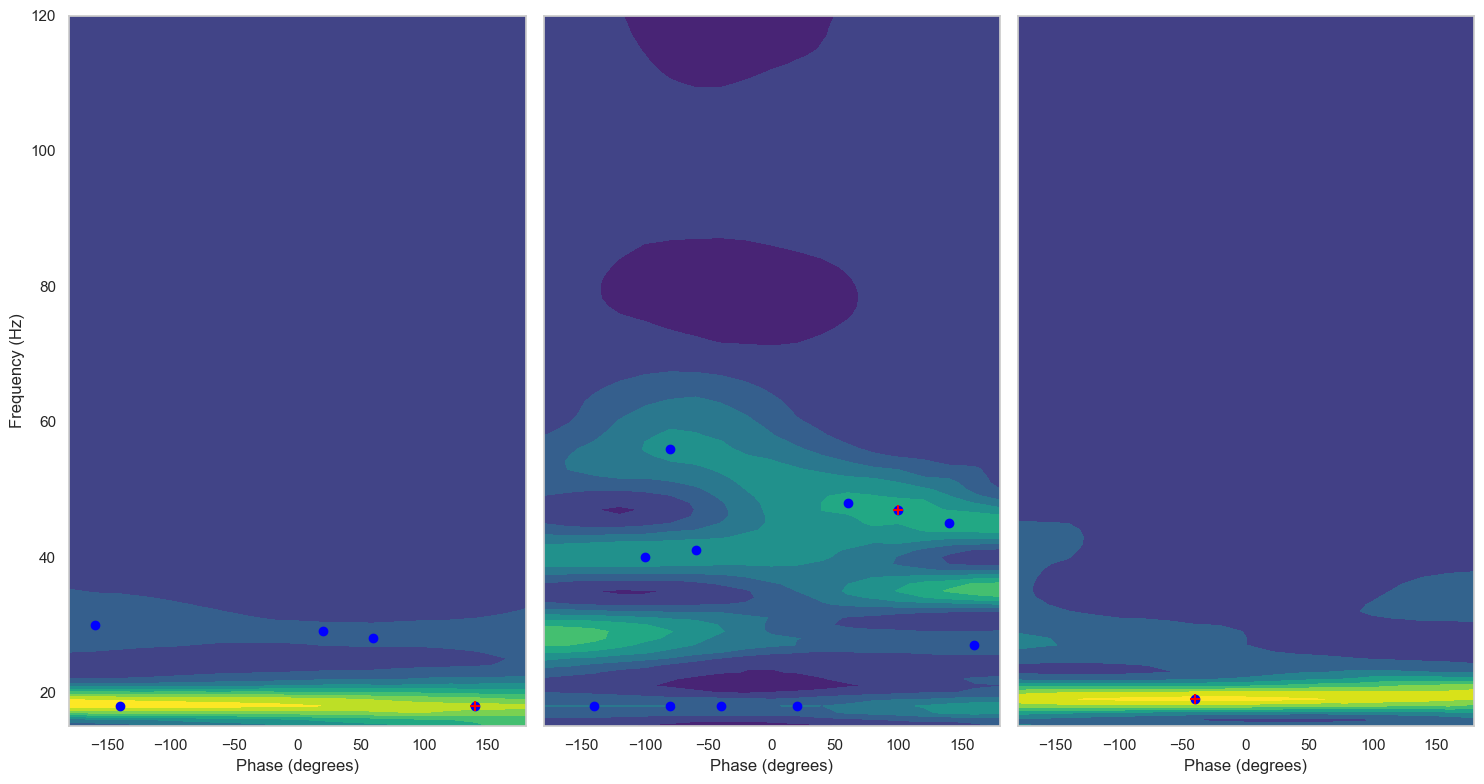

In [137]:
index = 12384
fig,ax = plt.subplots(1,3,figsize=(15,8), sharey=True)
ax[0].set_ylabel('Frequency (Hz)')
ax[0].contourf(angles,frequencies,fpp_cycles_one[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[0].scatter(fpp_peaks_one[index][:,1],fpp_peaks_one[index][:,0], color='blue')
ax[0].scatter(peaks_one[index,1],peaks_one[index,0], color='red',marker='+',s=50)
ax[1].contourf(angles,frequencies,fpp_cycles_two[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[1].scatter(fpp_peaks_two[index][:,1],fpp_peaks_two[index][:,0], color='blue')
ax[1].scatter(peaks_two[index,1],peaks_two[index,0], color='red', marker='+',s=50)
ax[2].contourf(angles,frequencies,fpp_cycles_three[index,:,:], vmin=-2, vmax=6,cmap ='viridis')
ax[2].scatter(fpp_peaks_three[index][:,1],fpp_peaks_three[index][:,0], color='blue')
ax[2].scatter(peaks_three[index,1],peaks_three[index,0], color='red', marker='+',s=50)
ax[0].set_xlabel('Phase (degrees)')
ax[1].set_xlabel('Phase (degrees)')
ax[2].set_xlabel('Phase (degrees)')
plt.tight_layout()

In [138]:
spectral_signatures_one = np.mean(fpp_cycles_one,axis=2)
spectral_signatures_two = np.mean(fpp_cycles_two,axis=2)
spectral_signatures_three = np.mean(fpp_cycles_three,axis=2)

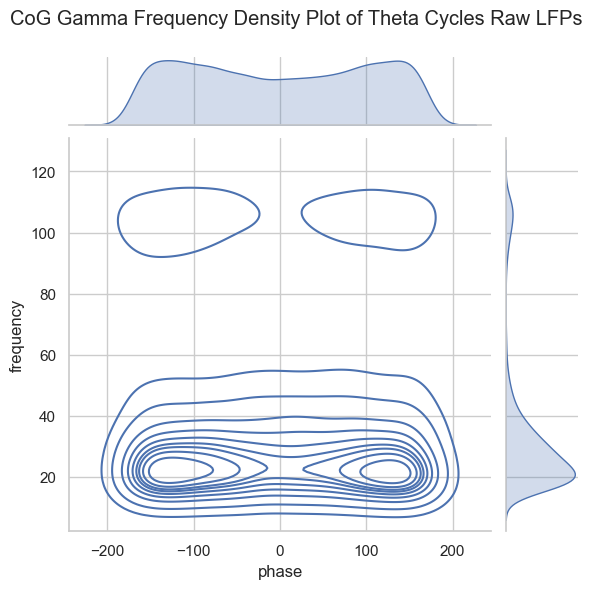

In [139]:
peaks_one_df = pd.DataFrame(columns=['frequency','phase'])
peaks_one_df['frequency'] = peaks_one[:,0]
peaks_one_df['phase'] = peaks_one[:,1]
g = sns.JointGrid(data=peaks_one_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Gamma Frequency Density Plot of Theta Cycles Raw LFPs")
g.fig.subplots_adjust(top=0.9)
g.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_CoG_Raw.png'))

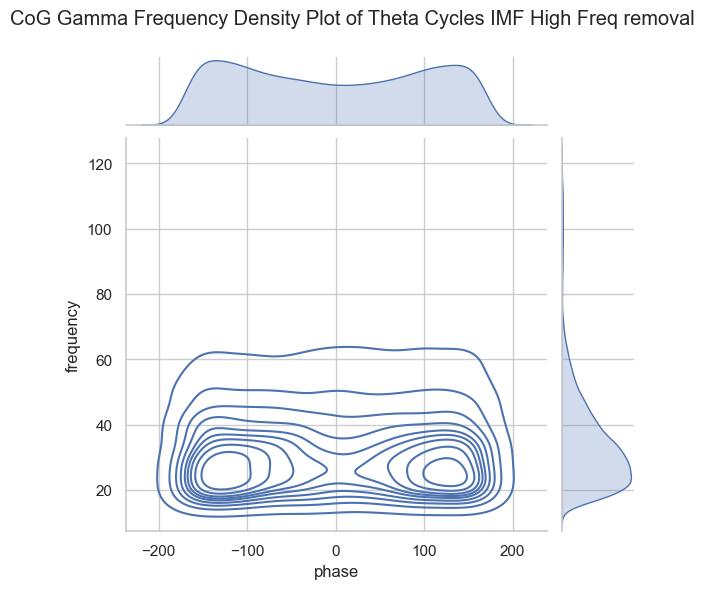

In [140]:
peaks_two_df = pd.DataFrame(columns=['frequency','phase'])
peaks_two_df['frequency'] = peaks_two[:,0]
peaks_two_df['phase'] = peaks_two[:,1]
g = sns.JointGrid(data=peaks_two_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Gamma Frequency Density Plot of Theta Cycles IMF High Freq removal")
g.fig.subplots_adjust(top=0.9)
g.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_CoG_High_Freq_Removal.png'))

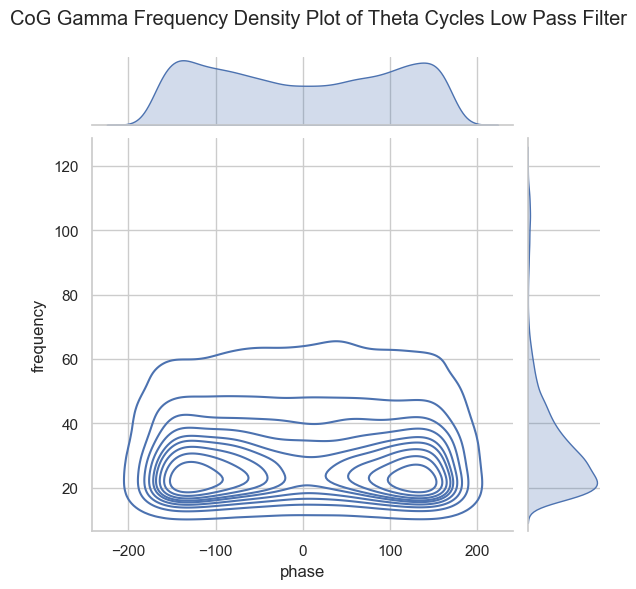

In [141]:
peaks_three_df = pd.DataFrame(columns=['frequency','phase'])
peaks_three_df['frequency'] = peaks_three[:,0]
peaks_three_df['phase'] = peaks_three[:,1]
g = sns.JointGrid(data=peaks_three_df, x="phase", y="frequency")
g = g.plot_joint(sns.kdeplot)
g = g.plot_marginals(sns.kdeplot, fill=True)
g.fig.suptitle("CoG Gamma Frequency Density Plot of Theta Cycles Low Pass Filter")
g.fig.subplots_adjust(top=0.9)
g.savefig(os.path.join(os.getcwd(),r'figures',f'{region_select}_CoG_Low_Pass_Filter.png'))

In [142]:
def find_peaks_bool_array(signals):
    """
    Find all relative maxima in an array of 1D signals and return a boolean array for each signal.

    Parameters:
    - signals: A 2D numpy array where each row represents a signal.

    Returns:
    - A 2D boolean array with the same shape as 'signals', where True indicates a peak and False otherwise
      for each signal in the input array.
    """
    num_signals, signal_length = signals.shape

    # Initialize a 2D boolean array with False values
    peaks_bool_array = np.zeros_like(signals, dtype=bool)

    for i in range(num_signals):
        # Find relative maxima indices using argrelmax for each signal
        maxima_indices = signal.argrelmax(signals[i])[0]

        # Set the indices of relative maxima to True for the current signal
        peaks_bool_array[i, maxima_indices] = True

    return peaks_bool_array

# Example usage with an array of signals:

In [143]:
freq_signatures_one = find_peaks_bool_array(spectral_signatures_one)*frequencies
freq_signatures_two = find_peaks_bool_array(spectral_signatures_two)*frequencies
freq_signatures_three = find_peaks_bool_array(spectral_signatures_three)*frequencies

freq_signatures_one = freq_signatures_one.flatten()
freq_signatures_two = freq_signatures_two.flatten()
freq_signatures_three =freq_signatures_three.flatten()

freq_signatures_one = freq_signatures_one[freq_signatures_one > 0]
freq_signatures_two = freq_signatures_two[freq_signatures_two > 0]
freq_signatures_three = freq_signatures_three[freq_signatures_three > 0]

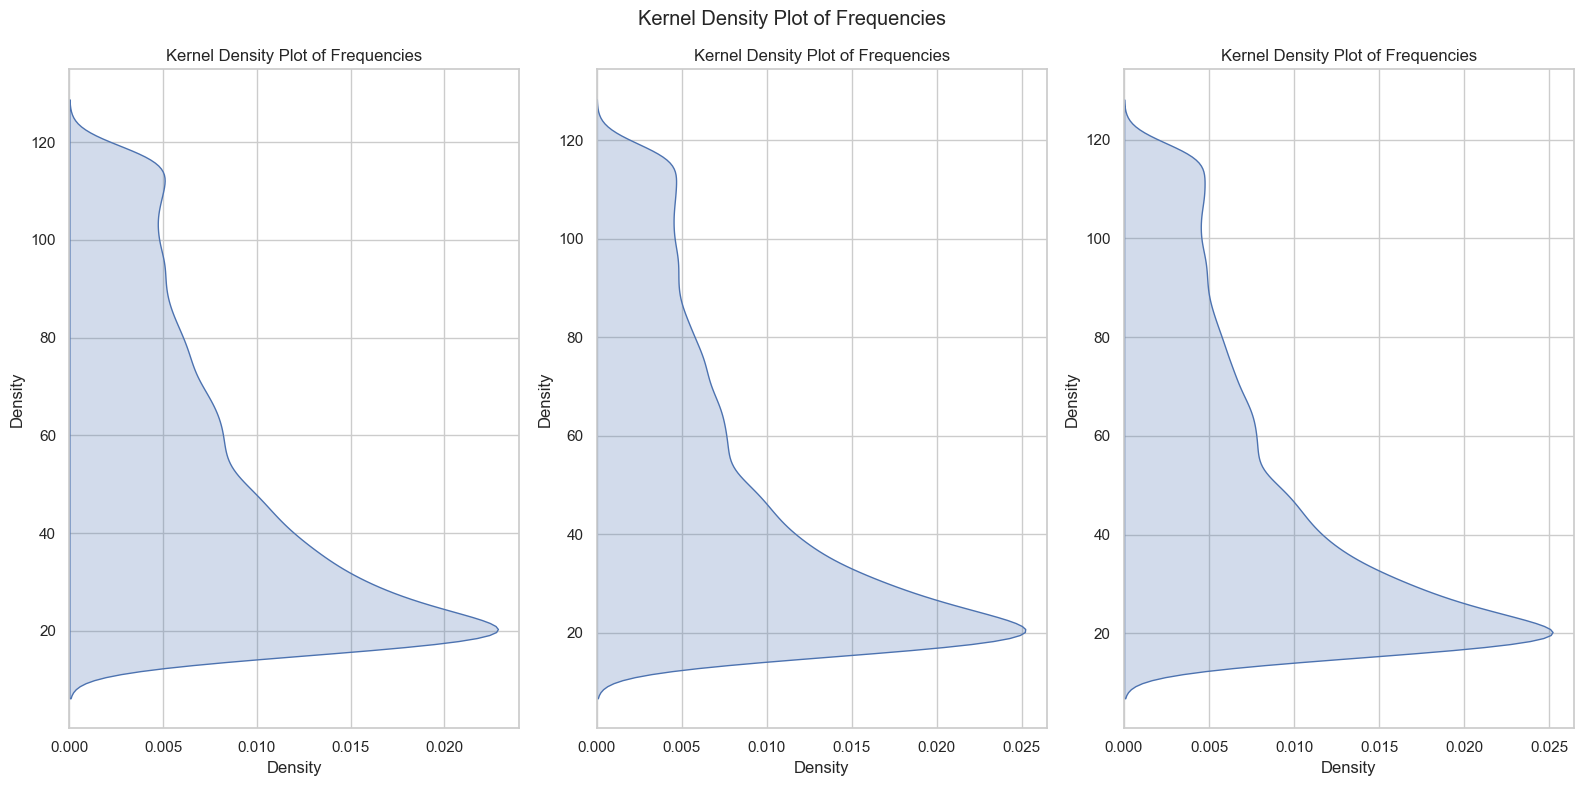

In [144]:
fig1, axes = plt.subplots(1, 3, figsize=(16, 8))  # Adjust the figure size as needed
sns.set(style="whitegrid")

sns.kdeplot(y=freq_signatures_one, ax=axes[0], fill=True)
axes[0].set_ylabel("Density")
axes[0].set_title("Kernel Density Plot of Frequencies")

sns.kdeplot(y=freq_signatures_two, ax=axes[1], fill=True)
axes[1].set_ylabel("Density")
axes[1].set_title("Kernel Density Plot of Frequencies")

sns.kdeplot(y=freq_signatures_three, ax=axes[2], fill=True)
axes[2].set_ylabel("Density")
axes[2].set_title("Kernel Density Plot of Frequencies")

fig1.suptitle('Kernel Density Plot of Frequencies')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()